# 특성 공학과 규제

## 데이터 준비

In [64]:
import numpy as np
import pandas as pd

df = pd.read_csv('https://bit.ly/perch_csv')
df.head()

,length,height,width
0,8.4,2.11,1.41
1,13.7,3.53,2.00
2,15.0,3.82,2.43
3,16.2,4.59,2.63
4,17.4,4.59,2.94


In [65]:
perch_full = df.to_numpy()
print(perch_full[:5])

[[ 8.4   2.11  1.41]
 [13.7   3.53  2.  ]
 [15.    3.82  2.43]
 [16.2   4.59  2.63]
 [17.4   4.59  2.94]]


In [66]:
perch_weight = np.array([5.9, 32.0, 40.0, 51.5, 70.0, 100.0, 78.0, 80.0, 85.0, 85.0,
                         110.0, 115.0, 125.0, 130.0, 120.0, 120.0, 130.0, 135.0, 110.0,
                         130.0, 150.0, 145.0, 150.0, 170.0, 225.0, 145.0, 188.0, 180.0,
                         197.0, 218.0, 300.0, 260.0, 265.0, 250.0, 250.0, 300.0, 320.0,
                         514.0, 556.0, 840.0, 685.0, 700.0, 700.0, 690.0, 900.0, 650.0,
                         820.0, 850.0, 900.0, 1015.0, 820.0, 1100.0, 1000.0, 1100.0,
                         1000.0, 1000.0])

In [67]:
from sklearn.model_selection import train_test_split

train_input, test_input, train_target, test_target = train_test_split(perch_full, perch_weight, random_state=42)

## 사이킷런의 변환기

In [68]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures()
poly.fit([[2, 3]])

# 1, x1, x2, {x1}^2, {x2}^2, x1x2
print(poly.transform([[2, 3]]))

[[1. 2. 3. 4. 6. 9.]]


In [69]:
# bias (선형 모델에서 intercept의 역할) 열을 제거한 변환
poly = PolynomialFeatures(include_bias=False)
poly.fit([[2, 3]])

# x1, x2, {x1}^2, {x2}^2, x1x2
print(poly.transform([[2, 3]]))

[[2. 3. 4. 6. 9.]]


In [70]:
poly = PolynomialFeatures(include_bias=False)

# train_input 데이터 변환
poly.fit(train_input)
train_poly = poly.transform(train_input)

# test_input 데이터 변환 -> fit() 사용 X (통계적 특성을 이용하는 경우 훈련 데이터의 특성만 이용)
test_poly = poly.transform(test_input)

In [71]:
train_input.shape, train_poly.shape

((42, 3), (42, 9))

In [72]:
poly.get_feature_names_out()

array(['x0', 'x1', 'x2', 'x0^2', 'x0 x1', 'x0 x2', 'x1^2', 'x1 x2',
       'x2^2'], dtype=object)

## 다중 회귀 모델 훈련하기

In [73]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(train_poly, train_target)
print(f'train score: {lr.score(train_poly, train_target)}')
print(f'test score: {lr.score(test_poly, test_target)}')

train score: 0.9903183436982125
test score: 0.9714559911594168


In [74]:
# 최대 차수를 5 (x^5)로 하는 PolynomialFeatures 생성
poly = PolynomialFeatures(degree=5, include_bias=False)
poly.fit(train_input)

train_poly = poly.transform(train_input)
test_poly = poly.transform(test_input)

In [75]:
train_input.shape, train_poly.shape

((42, 3), (42, 55))

In [76]:
lr.fit(train_poly, train_target)

# 과대적합(overfitting) 발생
print(lr.score(train_poly, train_target))
print(lr.score(test_poly, test_target))

0.9999999999989608
-144.4049046409093


## 규제

In [77]:
from sklearn.preprocessing import StandardScaler

# StandardScaler를 사용한 데이터 전처리
ss = StandardScaler()
ss.fit(train_poly)

# train 데이터의 통계값(평균, 표준편차)을 이용해 train, test 데이터 변환
train_scaled = ss.transform(train_poly)
test_scaled = ss.transform(test_poly)

## 릿지

In [78]:
from sklearn.linear_model import Ridge

ridge = Ridge() # 계수의 제곱 값을 기준으로 규제 적용
ridge.fit(train_scaled, train_target)

print(ridge.score(train_scaled, train_target))
print(ridge.score(test_scaled, test_target))

0.9896101671037343
0.9790693977615388


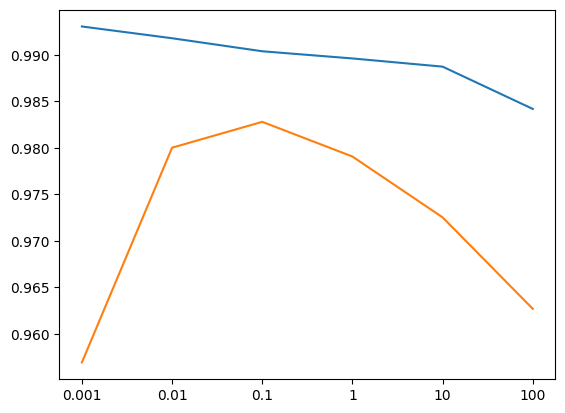

In [79]:
import matplotlib.pyplot as plt

train_score = []
test_score = []

alpha_list = [0.001, 0.01, 0.1, 1, 10, 100]
for alpha in alpha_list:
    
    # alpha (규제 강도)를 조절하며 Ridge 모델 학습
    ridge = Ridge(alpha=alpha)
    ridge.fit(train_scaled, train_target)
    
    # alpha의 변화에 따른 score 계산
    train_score.append(ridge.score(train_scaled, train_target))
    test_score.append(ridge.score(test_scaled, test_target))

# 결과 시각화
plt.plot(np.log10(alpha_list), train_score)
plt.plot(np.log10(alpha_list), test_score)
plt.xticks(np.log10(alpha_list), alpha_list)
plt.show()

In [80]:
# 실험을 통해 얻은 alpha 값으로 재학습
ridge = Ridge(alpha=0.1)
ridge.fit(train_scaled, train_target)

print(ridge.score(train_scaled, train_target))
print(ridge.score(test_scaled, test_target))

0.9903815817570366
0.9827976465386955


## 라쏘

In [81]:
from sklearn.linear_model import Lasso

lasso = Lasso() # 계수의 절댓값을 기준으로 규제 적용
lasso.fit(train_scaled, train_target)

print(lasso.score(train_scaled, train_target))
print(lasso.score(test_scaled, test_target))

0.989789897208096
0.9800593698421884


/Users/kimjinbeom/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.336e+04, tolerance: 5.183e+02
  model = cd_fast.enet_coordinate_descent(
/Users/kimjinbeom/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.025e+04, tolerance: 5.183e+02
  model = cd_fast.enet_coordinate_descent(
/Users/kimjinbeom/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the

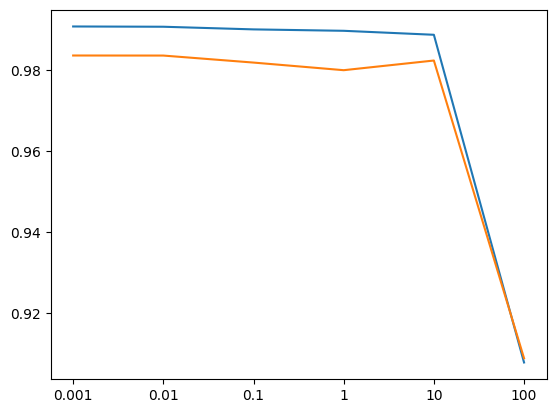

In [82]:
train_score = []
test_score = []

alpha_list = [0.001, 0.01, 0.1, 1, 10, 100]
for alpha in alpha_list:
    
    # alpha (규제 강도)를 조절하며 Lasso 모델 학습
    lasso = Lasso(alpha=alpha, max_iter=1000)
    lasso.fit(train_scaled, train_target)
    
    # alpha의 변화에 따른 score 계산
    train_score.append(lasso.score(train_scaled, train_target))
    test_score.append(lasso.score(test_scaled, test_target))

plt.plot(np.log10(alpha_list), train_score)
plt.plot(np.log10(alpha_list), test_score)
plt.xticks(np.log10(alpha_list), alpha_list)
plt.show()

In [83]:
# 실험을 통해 얻은 alpha 값으로 재학습
lasso = Lasso(alpha=10)
lasso.fit(train_scaled, train_target)

print(lasso.score(train_scaled, train_target))
print(lasso.score(test_scaled, test_target))

0.9888067471131867
0.9824470598706695


In [84]:
# 각 모델들의 계수 값 비교 -> 규제를 적용하지 않은 lr의 경우 계수 값이 매우 큼
lr.coef_, ridge.coef_, lasso.coef_ 

(array([-2.09046718e+04, -1.28162431e+03, -5.60555082e+03,  2.08209947e+03,
         1.22306320e+03, -1.43811127e+03, -4.56983352e+03, -5.32949477e+02,
         6.00775432e+03, -2.10700367e+01, -6.87051459e+01, -1.38715932e+03,
        -1.07542923e+03,  3.95341542e+03,  5.36645085e+03,  3.82365759e+03,
        -5.41558830e+03, -7.44635825e+03, -3.57636979e+03, -8.27969617e+00,
         3.60925119e+02, -4.02979342e+02, -3.16250553e+03,  3.78215640e+03,
         1.35365920e+03,  9.49657060e+03, -9.03104296e+03, -7.05268484e+03,
        -5.77056631e+03, -9.30076913e+03,  5.09439655e+03,  9.77726032e+03,
         9.37625047e+03,  7.91926010e+03, -2.17015032e+00,  3.18824757e+01,
         1.05759413e+01,  1.25135873e+02, -1.16342369e+03,  8.34254304e+02,
        -1.83471119e+03,  7.09688235e+03, -1.74934516e+03, -3.82030600e+03,
         5.50872384e+03, -1.57849420e+04, -1.46768258e+03,  8.08760970e+03,
         8.01725507e+03, -5.22495355e+03,  1.18579355e+04,  6.17614521e+03,
        -7.0

In [85]:
# 계수 값이 0인 개수 출력 -> 모델이 중요하다 판단한 특성(예측에 사용하는 특성)을 추출 가능
print(np.sum(lasso.coef_==0))

40


# 로지스틱 회귀

## 럭키백의 확률

### 데이터 준비하기

In [86]:
fish = pd.read_csv('https://bit.ly/fish_csv')
fish.head()

,Species,Weight,Length,Diagonal,Height,Width
0,Bream,242.0,25.4,30.0,11.5200,4.0200
1,Bream,290.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,26.5,31.1,12.3778,4.6961
3,Bream,363.0,29.0,33.5,12.7300,4.4555
4,Bream,430.0,29.0,34.0,12.4440,5.1340


In [87]:
print(pd.unique(fish['Species']))

['Bream' 'Roach' 'Whitefish' 'Parkki' 'Perch' 'Pike' 'Smelt']


In [88]:
fish_input = fish[['Weight', 'Length', 'Diagonal', 'Height', 'Width']].to_numpy()
print(fish_input[:5])

[[242.      25.4     30.      11.52     4.02  ]
 [290.      26.3     31.2     12.48     4.3056]
 [340.      26.5     31.1     12.3778   4.6961]
 [363.      29.      33.5     12.73     4.4555]
 [430.      29.      34.      12.444    5.134 ]]


In [89]:
fish_target = fish['Species'].to_numpy()
fish_target[:5]

array(['Bream', 'Bream', 'Bream', 'Bream', 'Bream'], dtype=object)

In [90]:
train_input, test_input, train_target, test_target = train_test_split(fish_input, fish_target, random_state=42)

In [91]:
ss = StandardScaler()
ss.fit(train_input)

train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

### k-최근접 이웃 분류기의 확률 예측

In [92]:
from sklearn.neighbors import KNeighborsClassifier

# n_neighbors=3으로 설정해 모델 학습
kn = KNeighborsClassifier(n_neighbors=3)
kn.fit(train_scaled, train_target)

print(kn.score(train_scaled, train_target))
print(kn.score(test_scaled, test_target))

0.8907563025210085
0.85


In [93]:
# knn에서는 target을 알파벳 순으로 정렬 (pd.unique() 와 다른 결과)
print(kn.classes_)

['Bream' 'Parkki' 'Perch' 'Pike' 'Roach' 'Smelt' 'Whitefish']


In [94]:
print(kn.predict(test_scaled[:5]))

['Perch' 'Smelt' 'Pike' 'Perch' 'Perch']


In [95]:
# class 별 확률 계산
proba = kn.predict_proba(test_scaled[:5])

# 다섯 번째 자리에서 반올림
print(np.round(proba, decimals=4)) 

[[0.     0.     1.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     1.     0.    ]
 [0.     0.     0.     1.     0.     0.     0.    ]
 [0.     0.     0.6667 0.     0.3333 0.     0.    ]
 [0.     0.     0.6667 0.     0.3333 0.     0.    ]]


In [96]:
distances, indexes = kn.kneighbors(test_scaled[3:4]) # test_scaled[3:4] == [test_scaled[3]]
print(train_target[indexes])

[['Roach' 'Perch' 'Perch']]


## 로지스틱 회귀

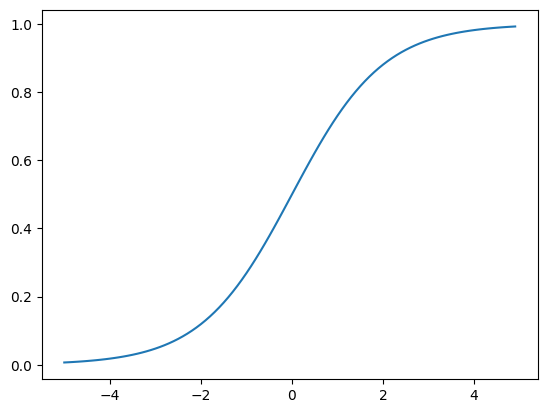

In [97]:
import numpy as np
import matplotlib.pyplot as plt

# -5 ~ 5 사이의 값
z = np.arange(-5, 5, 0.1)

# 시그모이드 함수 계산
phi = 1 / (1 + np.exp(-z))

# 결과 시각화
plt.plot(z, phi)
plt.show()

### 로지스틱 회귀로 이진 분류 수행하기

In [98]:
char_arr = np.array(['A', 'B', 'C', 'D', 'E'])
print(char_arr[[True, False, True, False, False]]) # boolean indexing 적용

['A' 'C']


In [99]:
# Bream / Smelt에 해당하는 인덱스 추출
# 
bream_smelt_indexes = (train_target == "Bream") | (train_target == "Smelt")

In [100]:
# train, target 데이터 생성
train_bream_smelt = train_scaled[bream_smelt_indexes]
target_bream_smelt = train_target[bream_smelt_indexes]

In [101]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(train_bream_smelt, target_bream_smelt)

print(lr.predict(train_bream_smelt[:5]))

['Bream' 'Smelt' 'Bream' 'Bream' 'Bream']


In [102]:
print(lr.predict_proba(train_bream_smelt[:5]))

[[0.99760007 0.00239993]
 [0.02737325 0.97262675]
 [0.99486386 0.00513614]
 [0.98585047 0.01414953]
 [0.99767419 0.00232581]]


In [103]:
print(lr.classes_)

['Bream' 'Smelt']


In [104]:
# (-0.4 * x0) + (-0.57 * x1) + (-0.66 * x2) + (-1.01 * x3) + (-0.73 * x4) + (-2.161)
print(lr.coef_, lr.intercept_)

[[-0.40451732 -0.57582787 -0.66248158 -1.01329614 -0.73123131]] [-2.16172774]


In [105]:
# 시그모이드 함수를 적용하기 전인 z값 출력
decisions = lr.decision_function(train_bream_smelt[:5])
print(decisions)

# 시그모이드 함수 적용
from scipy.special import expit
print(expit(decisions))

[-6.02991358  3.57043428 -5.26630496 -4.24382314 -6.06135688]
[0.00239993 0.97262675 0.00513614 0.01414953 0.00232581]


### 로지스틱 회귀로 다중 분류 수행하기

In [106]:
# C를 이용해 규제 강도 조절 (작을수록 강한 규제) -> ridge와 같은 L2 norm 규제 사용
lr = LogisticRegression(C=20, max_iter=1000)
lr.fit(train_scaled, train_target)

print(lr.score(train_scaled, train_target))
print(lr.score(test_scaled, test_target))

0.9327731092436975
0.925


In [107]:
print(lr.predict(test_scaled[:5]))

['Perch' 'Smelt' 'Pike' 'Roach' 'Perch']


In [108]:
proba = lr.predict_proba(test_scaled[:5])
print(np.round(proba, decimals=3))

[[0.    0.014 0.842 0.    0.135 0.007 0.003]
 [0.    0.003 0.044 0.    0.007 0.946 0.   ]
 [0.    0.    0.034 0.934 0.015 0.016 0.   ]
 [0.011 0.034 0.305 0.006 0.567 0.    0.076]
 [0.    0.    0.904 0.002 0.089 0.002 0.001]]


In [109]:
print(lr.classes_)

['Bream' 'Parkki' 'Perch' 'Pike' 'Roach' 'Smelt' 'Whitefish']


In [110]:
print(lr.coef_.shape, lr.intercept_.shape)

(7, 5) (7,)


In [111]:
decision = lr.decision_function(test_scaled[:5])
print(np.round(decision, decimals=2))

[[ -6.51   1.04   5.17  -2.76   3.34   0.35  -0.63]
 [-10.88   1.94   4.78  -2.42   2.99   7.84  -4.25]
 [ -4.34  -6.24   3.17   6.48   2.36   2.43  -3.87]
 [ -0.69   0.45   2.64  -1.21   3.26  -5.7    1.26]
 [ -6.4   -1.99   5.82  -0.13   3.5   -0.09  -0.7 ]]


In [112]:
from scipy.special import softmax

# 다중 분류의 경우 softmax 적용
proba = softmax(decision, axis=1)
print(np.round(proba, decimals=3))

[[0.    0.014 0.842 0.    0.135 0.007 0.003]
 [0.    0.003 0.044 0.    0.007 0.946 0.   ]
 [0.    0.    0.034 0.934 0.015 0.016 0.   ]
 [0.011 0.034 0.305 0.006 0.567 0.    0.076]
 [0.    0.    0.904 0.002 0.089 0.002 0.001]]
